# Mean Reversion & Moving Averages
## 1. Research Question
We want to explore the EUR-GBP exchange rate, and examine when and whether the process is mean reverting. If it is indeed mean reverting, then we can extract a half-life of mean reversion from the time signal, and use that to parametrize a moving average trading strategy.

## 2. Data & Mean Reversion Tests
For data, we pull the last 20 years of EURGBP data at a frequency of 1 day. We then look at approximately 3 year long windows (1100 days), starting approximately every quarter (90 days). We then run the ADF test on each block to determine whether the signal is mean reverting during this period or not. Specifically, we look windows when p < 0.05.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Example: Get EUR/CHF data
data = yf.download("EURGBP=X", start='2005-08-21', end='2025-08-21', interval='1d', auto_adjust=True)
data.describe()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,EURGBP=X,EURGBP=X,EURGBP=X,EURGBP=X,EURGBP=X
count,5207.000000,5207.000000,5207.000000,5207.000000,5207.0
mean,0.826734,0.829519,0.823910,0.826732,0.0
std,0.068432,0.068843,0.068996,0.068447,0.0
min,0.654900,0.657000,0.006600,0.654900,0.0
25%,0.795275,0.797965,0.792585,0.795480,0.0
50%,0.850190,0.853090,0.847700,0.850200,0.0
75%,0.873400,0.876940,0.870615,0.873450,0.0
max,0.979000,0.979700,0.967800,0.977500,0.0


In [2]:
start_idx = 0
end_idx = 1100
while True:
    # Extract subset
    df = data.iloc[start_idx:end_idx]

    # Extract close prices
    prices = df['Close'].dropna()

    # Run Augmented Dickey-Fuller test
    result = adfuller(prices)

    # Print results
    if result[1] < 0.05:
        print("start_idx, end_idx, ADF Statistic, p-value:", start_idx, end_idx, result[0], result[1])    

    # Move window forward by 90 days
    start_idx = start_idx + 90
    end_idx = end_idx + 90
    if end_idx > len(data):
        break
    

start_idx, end_idx, ADF Statistic, p-value: 630 1730 -2.9718516101512455 0.037608038707527755
start_idx, end_idx, ADF Statistic, p-value: 2700 3800 -3.33754841032919 0.013281248617050344
start_idx, end_idx, ADF Statistic, p-value: 2790 3890 -3.672694709270741 0.004514038903400763
start_idx, end_idx, ADF Statistic, p-value: 2880 3980 -3.7741369500855964 0.0031832931339030976
start_idx, end_idx, ADF Statistic, p-value: 2970 4070 -3.3403097381336004 0.013170010572767657
start_idx, end_idx, ADF Statistic, p-value: 3060 4160 -3.4025804030352877 0.010871219750181304
start_idx, end_idx, ADF Statistic, p-value: 3150 4250 -3.1829730339815683 0.02099166491397477


## 3. Extracting Half-Life of Mean Reversion
Great! Looks like there was a time window of a few years when the signal was mean reverting. Let's plot the signal to get a feel for it, then let's regress an AR(1) model on it to obtain a half-life value. 

Text(0, 0.5, 'GBP for 1 EUR')

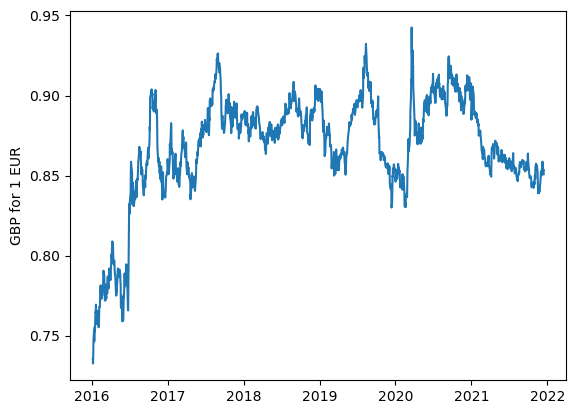

In [3]:
window_start = 2700
window_end = 4250
df = data.iloc[window_start:window_end]
plt.plot(df['Close'].dropna())
plt.ylabel('GBP for 1 EUR')

In [4]:
# Regression to find half life
y = df['Close'].dropna()

# Regress y_t on y_{t-1}
y_lag = y.shift(1).dropna()
y_ret = y.diff().dropna()  # Δy_t = y_t - y_{t-1}

# Align
y_lag = y_lag.loc[y_ret.index]

X = sm.add_constant(y_lag)  # add intercept
model = sm.OLS(y_ret, X).fit()

beta = model.params[1]  # coefficient on y_{t-1}

# 2. Convert to half-life
half_life = -np.log(2) / beta
print("Half-life:", half_life)

Half-life: 51.24236780923417


C:\Users\sunda\AppData\Local\Temp\ipykernel_10144\725049562.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]  # coefficient on y_{t-1}


## 4. Algorithm 1: Moving Z-score
# 4.1. The "when"
Now that we know the half-life of reversion is about 51 days, we can use that to implement a simple moving Z-score algorithm. The idea is pretty starightforward. We have a natural window to implement lookbacks. Using this, we can compute rolling means and standard deviations over this window. 

In [42]:
# Rolling mean & std over half-life window
lookback = 51  # half-life
rolling_mean = y.rolling(window=lookback).mean()
rolling_std  = y.rolling(window=lookback).std()

zscore = (y - rolling_mean) / rolling_std

# Example trading rule
entryZ = 2.0   # enter when |z| > 1
exitZ  = 0.0   # exit when z crosses 0

longs  = zscore < -entryZ   # If it goes down, 1 EUR = less GBP => buy EUR and sell GBP
shorts = zscore >  entryZ   # If it goes up, 1 EUR = more GBP => buy GBP and sell EUR
exits  = zscore.abs() < exitZ # Exit when position crosses mean, i.e., buy back all GBP as EUR at current "mean" value

# 4.2. The "how much"
How much do we trade when the signal says trade? Let's assume a simple strategy - when the signal says go long, buy 1 unit of EUR. When it says go short, sell 1 unit of EUR. When it says exit, buy back EUR using GBP until EUR back at original capital position.

C:\Users\sunda\AppData\Local\Temp\ipykernel_10144\3091678582.py:8: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if longs.iloc[t].bool():
C:\Users\sunda\AppData\Local\Temp\ipykernel_10144\3091678582.py:10: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif shorts.iloc[t].bool():
C:\Users\sunda\AppData\Local\Temp\ipykernel_10144\3091678582.py:12: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  elif exits.iloc[t].bool():


0.0036405488765385062 0.2566140427183089 -16.85940256929978
0.002836068279865007 0.2738912773496091 -15.798838041113363
0.0003929478181021937 0.3323461693801927 -13.027401700631534
-0.0037671152955993177 0.44963615106124505 -9.638386737958925
-0.012252224213571656 0.7608384298208221 -5.707193609076995


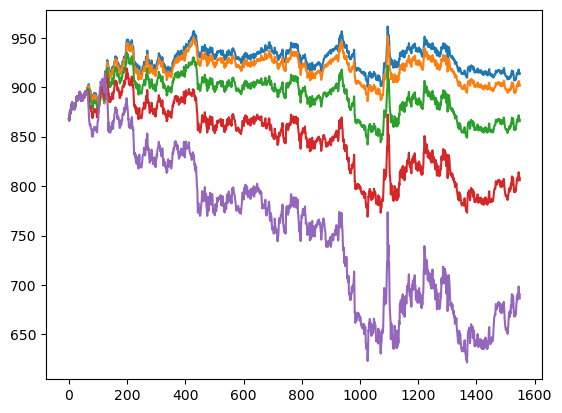

In [43]:
# Extract time stamps and prices
timestamps = y.index.tolist()
exchange = y['EURGBP=X'].values.tolist()

# First, we translate buy, sell and exit as +1, -1 and set to 0
position = [0]*len(y)
for t in range(1, len(y)):
    if longs.iloc[t].bool():
        position[t] = 1    # long 1 unit
    elif shorts.iloc[t].bool():
        position[t] = -1   # short 1 unit
    elif exits.iloc[t].bool():
        position[t] = -10  # exit
    else:
        position[t] = 0    # hold previous position

# Then we compute the percentage change in the FX exchange rate, then multiple that by position to get
total_vals = []
risk_free_rate = 4.33
plt.figure(1)
for pos_size in [1,2,5,10,20]: # Absolute returns scaled with position size, so normalize position size to 1 unit EUR
    eur_pos = 500
    gbp_pos = 500
    total_val = []
    eur_val = []
    gbp_val = []
    total_val = []
    for i in range(len(position)):
        if position[i] == -10:
            # Exit position by buying/selling EUR as needed until you're back to original capital
            diff = (eur_pos - 100)
            gbp_pos = gbp_pos + diff * exchange[i]
            eur_pos = 100
        else:
            # Buy/Sell/Do-nothing
            eur_pos = eur_pos + pos_size * position[i]
            gbp_pos = gbp_pos - pos_size * position[i] * exchange[i]
        eur_val.append(eur_pos)
        gbp_val.append(gbp_pos)
        total_val.append(eur_pos + gbp_pos * exchange[i])
    returns = [(total_val[i]-total_val[i-1])/total_val[i-1]*100 for i in range(1,len(total_val))]
    plt.plot(total_val)
    mean = sum(returns)/len(returns)
    std_dev = np.std(returns)
    print(mean, std_dev, (mean-risk_free_rate)/std_dev)
    

